# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil

### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
 # Effect size for a test comparing two proportions
effect_size = sms.proportion_effectsize(0.06, 0.09) 

In [3]:
# Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1)

# Rounding up to next whole number
required_n = ceil(required_n)
print(required_n)

1199


### Collecting and preparing the data

In [4]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv('tiktok_data.csv')
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Get the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [6]:
# Make sure all the control group are seeing the star button and viceversa
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [7]:
# Check that no users have been sampled multiple times 
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
multi_users

3453

In [8]:
# If there are users who have been sampled multiple times, remove them from the dataframe
users_to_drop  = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
df.shape[0]

268875

#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [9]:
# Perform simple random sampling to split the data into control and treatment
control_sample  = df[df['group'] == 'control'].sample(n=required_n, random_state=43)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=43)

In [10]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,button,liked
0,774505,2017-01-21 19:53:39,control,heart,0
1,904642,2017-01-21 23:39:27,control,heart,0
2,915706,2017-01-14 16:44:20,control,heart,1
3,719386,2017-01-06 12:10:09,control,heart,0
4,875251,2017-01-09 5:43:52,control,heart,0
...,...,...,...,...,...
2393,928258,2017-01-03 5:44:42,treatment,star,0
2394,821455,2017-01-19 5:26:01,treatment,star,0
2395,934579,2017-01-08 20:39:45,treatment,star,0
2396,797769,2017-01-06 14:39:10,treatment,star,0


In [11]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()

control      1199
treatment    1199
Name: group, dtype: int64

### Analysis Visualization

In [12]:
# Find the like rate by group
conversion_rates  = ab_test.groupby('group')['liked']

# Find the Std. deviation of the proportion

standard_deviation = lambda f: np.std(f, ddof=0)

# Find the Std. error of the proportion (std / sqrt(n))

standard_error = lambda f: stats.sem(f, ddof=0)


# Calculate the final like rate
conversion_rates = conversion_rates.agg([np.mean, standard_deviation, standard_error])
conversion_rates.columns = ['conversion', 'standard_deviation', 'standard_error']
conversion_rates.style.format('{:.4f}')

,conversion,standard_deviation,standard_error
group,,,
control,0.1151,0.3191,0.0092
treatment,0.1168,0.3211,0.0093


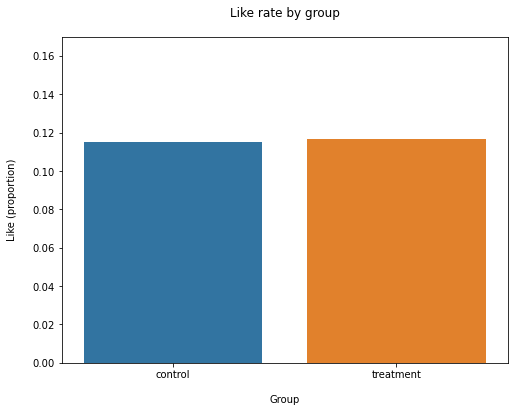

In [13]:
# Plot the like rate by group on a bar plot
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['liked'], ci=False)

plt.ylim(0, 0.17)
plt.title('Like rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Like (proportion)', labelpad=15);

### Testing for Stat Sig

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
# Get the like count for both control and treatment groups

control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

# Get the number of samples in both groups

n_con = control_results.count()
n_treat  = treatment_results.count()

# Sum up the number of successes (likes) in both groups

successes  = [control_results.sum(), treatment_results.sum()]

n_con, n_treat, successes


(1199, 1199, [138, 140])

In [15]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest([control_results.sum(), treatment_results.sum()], nobs=[n_con, 
                                                                                         n_treat])

# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint([control_results.sum(), treatment_results.sum()], 
                                                                        nobs=[n_con, n_treat], alpha=0.05)

In [16]:
# print z statistic
# print p-value
# print ci 95% for control group
# print ci 95% for treatment group
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.13
p-value: 0.898
ci 95% for control group: [0.097, 0.133]
ci 95% for treatment group: [0.099, 0.135]


In [17]:
conversion_rates.style.format('{:.3f}')

,conversion,standard_deviation,standard_error
group,,,
control,0.115,0.319,0.009
treatment,0.117,0.321,0.009


### Were the results signficant? 

In [18]:
"""P-Value is 0.898 because this is a one-tail test and the value is greater-than(>) our alpha signifigant level of 0.05 which indicates accept our Null Hypothesis"""

'P-Value is 0.898 because this is a one-tail test and the value is greater-than(>) our alpha signifigant level of 0.05 which indicates accept our Null Hypothesis'

### What would you advise the engineering team to do moving forward?

In [19]:
'''I advise that we should move forward'''

'I advise that we should move forward'